# Setup

In this section all libraries needed to run this notebook are imported.

In [6]:
# packages for data processing
import pandas as pd
import numpy as np

# packages for modelling
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
# from sklearn.utils.fixes import loguniform
import lightgbm as lgb

# packages for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# set random seed
SEED = 42

# Read Data

Read the data into a pandas dataframe and plot the first rows.

In [7]:
df_water = pd.read_csv("./water_potability.csv")
df_water.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/water-potability/water_potability.csv'

The dataset is described as follows:

|variable| information|
|--------|------------|
| pH value | PH is an important parameter in evaluating the acid–base balance of water. It is also the indicator of acidic or alkaline condition of water status. WHO has recommended maximum permissible limit of pH from 6.5 to 8.5. The current investigation ranges were 6.52–6.83 which are in the range of WHO standards.|
| Hardness | Hardness is mainly caused by calcium and magnesium salts. These salts are dissolved from geologic deposits through which water travels. The length of time water is in contact with hardness producing material helps determine how much hardness there is in raw water. Hardness was originally defined as the capacity of water to precipitate soap caused by Calcium and Magnesium. |
| Solids (Total dissolved solids - TDS)|  Water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc. These minerals produced un-wanted taste and diluted color in appearance of water. This is the important parameter for the use of water. The water with high TDS value indicates that water is highly mineralized. Desirable limit for TDS is 500 mg/l and maximum limit is 1000 mg/l which prescribed for drinking purpose.|
| Chloramines | Chlorine and chloramine are the major disinfectants used in public water systems. Chloramines are most commonly formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.|
| Sulfate| Sulfates are naturally occurring substances that are found in minerals, soil, and rocks. They are present in ambient air, groundwater, plants, and food. The principal commercial use of sulfate is in the chemical industry. Sulfate concentration in seawater is about 2,700 milligrams per liter (mg/L). It ranges from 3 to 30 mg/L in most freshwater supplies, although much higher concentrations (1000 mg/L) are found in some geographic locations.|
| Conductivity| Pure water is not a good conductor of electric current rather’s a good insulator. Increase in ions concentration enhances the electrical conductivity of water. Generally, the amount of dissolved solids in water determines the electrical conductivity. Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current. According to WHO standards, EC value should not exceeded 400 μS/cm.|
| Organic_carbon | Total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water. According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment.|
| Trihalomethanes | THMs are chemicals which may be found in water treated with chlorine. The concentration of THMs in drinking water varies according to the level of organic material in the water, the amount of chlorine required to treat the water, and the temperature of the water that is being treated. THM levels up to 80 ppm is considered safe in drinking water.|
| Turbidity | The turbidity of water depends on the quantity of solid matter present in the suspended state. It is a measure of light emitting properties of water and the test is used to indicate the quality of waste discharge with respect to colloidal matter. The mean turbidity value obtained for Wondo Genet Campus (0.98 NTU) is lower than the WHO recommended value of 5.00 NTU.|
| Potability | Indicates if water is safe for human consumption where 1 means Potable and 0 means Not potable. (TARGET)|

# Data Exploration

Explore the dataframe, the possible features and the target variable.

Check all columns and their types.

In [ ]:
df_water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


**Observations**
* In total the dataframe has 3276 rows
* ph, Sulfate, and Trihalomethanes have missing values
* There are 9 possible input feature and one target variable, which is 'Potability'
* The target variable 'Potability' is of type integer, all the others are of type float, i.e. we don't need to convert any types

**Note**, that we don't need to remove the **missing values**, because LightGBM natively supports the treatment of [missing value](https://lightgbm.readthedocs.io/en/stable/Advanced-Topics.html#missing-value-handle).

Show basic statistics of all columns

In [ ]:
df_water.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


**Observations**
* Input feaures vary in their range
* The target variable is binary

Plot data distributions

In [ ]:
def distplots(df=df_water,n=8):
    cols = list(df.columns)
    fig, axes = plt.subplots(5, 2, figsize=(15,8))
    plt.tight_layout(pad=3)
    for col, ax in enumerate(axes.flatten()):
        if df[cols[col]].dtypes=='float64':
            sns.boxplot(x=df[cols[col]], ax=ax, color='darkcyan')
        if col>n:
            break;

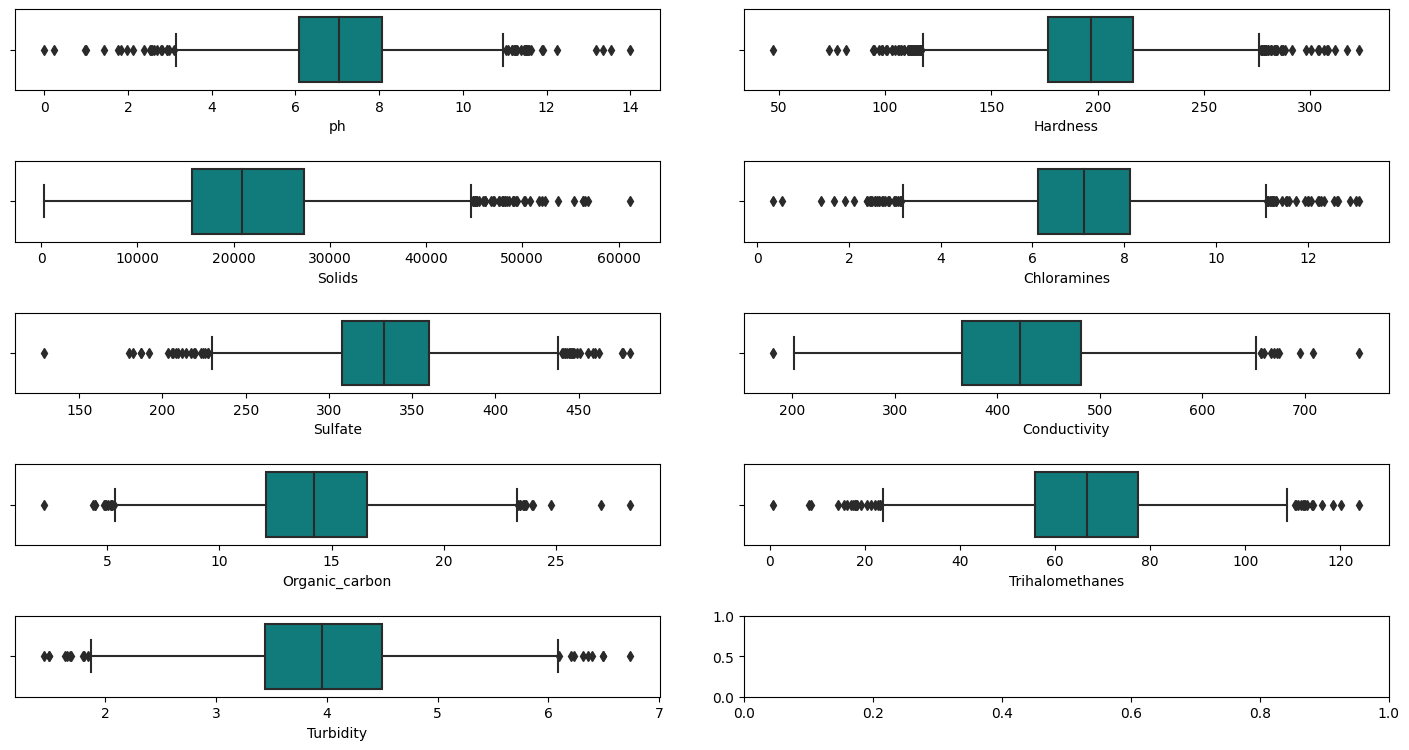

In [ ]:
distplots(df=df_water)

In [ ]:
df_water['Potability'].value_counts()

Potability
0    1998
1    1278
Name: count, dtype: int64

**Observations**
* There are no extreme outliers
* Most of the input feature are normally distributed
* 'Solids' and 'Conductivity' seem to be right-skewed (no statistical test done here, only from visual inspection)
* The target variable is not equally distributed, but their are more samples with a negative target class than a positive

# Data Preparation

Split the data into training, validation and test set. 

In [ ]:
# train - validation split
df_train_full, df_test = train_test_split(df_water, test_size=0.2, shuffle=True, random_state=SEED)
df_train, df_valid = train_test_split(df_train_full, test_size=0.25, shuffle=True, random_state=SEED)
print(f'train data shape: X - {df_train.shape}, y - {df_train["Potability"].shape}')
print(f'validation data shape: X - {df_valid.shape}, y - {df_valid["Potability"].shape}')
print(f'test data shape: X - {df_test.shape}, y - {df_test["Potability"].shape}')

train data shape: X - (1965, 10), y - (1965,)
validation data shape: X - (655, 10), y - (655,)
test data shape: X - (656, 10), y - (656,)


We equalize the two target classes. If we don't do this, the majority class will dominate the model. There are different options
1. Downsanḿpling. Draw randomly the number of samples of the minority class from the majority class. This leads to a loss of data.
2. Upsampling.
​
    a) Randomly draw samples from the minority class until the number of the ajority class is achieved. This leads o dubplicate samples in the dataset and can lead to overfitting.
    
    b) Create artificial data using e.g. [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) from the minority class until the number of samples of the majority class is achieved.


For this example we will use option 1 for simplicity. Note that if upsampling is done, this is done for the training data only. Otherwise data leakage may occur, that is we may use data for training that is also in tha validation or test set.

In [ ]:
df_majority = df_train[df_train.Potability==0]
df_minority = df_train[df_train.Potability==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.Potability.value_counts()

Potability
0    1189
1    1189
Name: count, dtype: int64

# Modelling

Set features and target values of train, validation, and test set.


In [ ]:
features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

X_train = df_train[features]
X_valid = df_valid[features]
X_test = df_test[features]

y_train = df_train['Potability']
y_valid = df_valid['Potability']
y_test = df_test['Potability']

Set the parameters to train the model.

In [ ]:
params = {
    'boosting_type': 'gbdt',           # Gradient Boosting Decision Tree
    'objective': 'binary',             # Binary classification task
    'metric': 'binary_logloss',        # Metric to evaluate
    'num_leaves': 31,                  # Maximum number of leaves in one tree
    'learning_rate': 0.05,             # Learning rate
    'feature_fraction': 0.9,           # Percentage of features to consider for each boosting round
    'bagging_fraction': 0.8,           # Percentage of data to use for each boosting round
    'bagging_freq': 5,                 # Perform bagging every 5 iterations
    'max_depth': -1,                   # Maximum depth of the tree (-1 means no limit)
    'min_data_in_leaf': 20,            # Minimum number of samples in one leaf
    'lambda_l1': 0.1,                  # L1 regularization term
    'lambda_l2': 0.2,                  # L2 regularization term
    'verbosity': 1                     # LightGBM's output
}

Initialize the LightGBM classifier with the specified hyperparameters and fit the model. Additionally we set a [callback](https://lightgbm.readthedocs.io/en/latest/Python-API.html) for early stopping to get the best model, once the loss doesn´t improve any more.

In [ ]:
clf = lgb.LGBMClassifier(**params, n_estimators=1000)

clf.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], 
        eval_metric='logloss', 
        callbacks=[lgb.early_stopping(stopping_rounds=30)])

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. C

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
               lambda_l1=0.1, lambda_l2=0.2, learning_rate=0.05,
               metric='binary_logloss', min_data_in_leaf=20, n_estimators=1000,
               objective='binary', verbosity=1)

**Evaluation**

We calculate Accuracy, Recall, and Precision for the three data splits for both models.

In [ ]:
print("training:")
y_train_pred = clf.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train_pred, y_train):.3f}, Recall: {recall_score(y_train_pred, y_train):.3f}, Precision: {precision_score(y_train_pred, y_train):.3f}")
print("\nvalidation:")
y_valid_pred = clf.predict(X_valid)
print(f"Accuracy: {accuracy_score(y_valid_pred, y_valid):.3f}, Recall: {recall_score(y_valid_pred, y_valid):.3f}, Precision: {precision_score(y_valid_pred, y_valid):.3f}")
print("\ntest:")
y_test_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_pred, y_test):.3f}, Recall: {recall_score(y_test_pred, y_test):.3f}, Precision: {precision_score(y_test_pred, y_test):.3f}")

training:
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Accuracy: 0.894, Recall: 0.966, Precision: 0.758

validation:
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[Lig

**Observations**

This model is overfitting quite a bit. Let's see if the results can be improved if we tune the hyperparameters.

### Hyperparameter Tuning

We will now use hyperparameter tuning to see if the model can be improved. We will only use a selected set of the hyperparameters, so that tuning won't take too long.


In [ ]:
param_grid = {
    'n_estimators': [1000],
    'num_leaves': [20, 31, 50],
    'learning_rate': [0.001, 0.05],     
    'max_depth': [5, 10],                      
    'lambda_l1': [0.1],                  
    'lambda_l2': [0.2],  
    'verbosity': [-1]
}

clf = lgb.LGBMClassifier(eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                        eval_metric='logloss', 
                        callbacks=[lgb.early_stopping(stopping_rounds=30)])

grid_search = GridSearchCV(
    estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)
 

grid_search.fit(X_train.values, y_train.values)

NameError: name 'lgb' is not defined

Fit the model with the best paramters.

In [ ]:
parameters = grid_search.best_params_
parameters["early_stopping_rounds"] = 10
parameters

NameError: name 'grid_search' is not defined

In [ ]:
clf = lgb.LGBMClassifier(**parameters)
clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

NameError: name 'lgb' is not defined

In [ ]:
print("training:")
y_train_pred = clf.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train_pred, y_train):.3f}, Recall: {recall_score(y_train_pred, y_train):.3f}, Precision: {precision_score(y_train_pred, y_train):.3f}")
print("\nvalidation:")
y_valid_pred = clf.predict(X_valid)
print(f"Accuracy: {accuracy_score(y_valid_pred, y_valid):.3f}, Recall: {recall_score(y_valid_pred, y_valid):.3f}, Precision: {precision_score(y_valid_pred, y_valid):.3f}")
print("\ntest:")
y_test_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_pred, y_test):.3f}, Recall: {recall_score(y_test_pred, y_test):.3f}, Precision: {precision_score(y_test_pred, y_test):.3f}")

training:
Accuracy: 0.781, Recall: 0.920, Precision: 0.487

validation:
Accuracy: 0.652, Recall: 0.632, Precision: 0.279

test:
Accuracy: 0.683, Recall: 0.667, Precision: 0.295


We see that just with a little bit of hyperparameter tuning we could improve the results and reduce the overfitting. Further tuning might lead to further improvement. But for the purpose of this notebook we will stop here.

Using LightGBM we can easily get the feature importances.

In [ ]:
importance = clf.feature_importances_
feature_names = [f'{X_valid.columns[i]}' for i in range(X_valid.shape[1])]
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
print(feature_importance.sort_values(by='importance', ascending=False))

           feature  importance
0               ph         195
4          Sulfate         167
1         Hardness         122
3      Chloramines         106
2           Solids          99
7  Trihalomethanes          93
6   Organic_carbon          68
5     Conductivity          62
8        Turbidity          34


**Footnote**

Find more about Data Science and Machine Learning [here](https://datamapu.com/)

In [ ]:
## Confusion matrix 

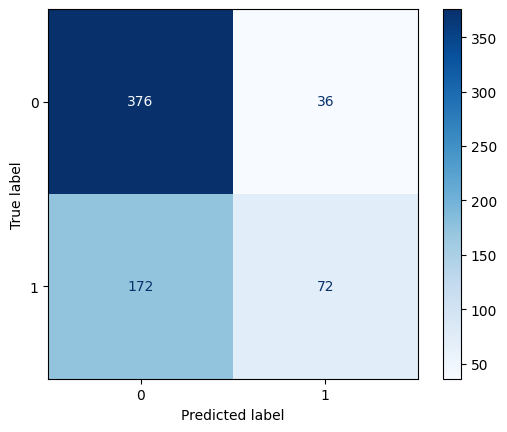

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
## Similarity matrix 

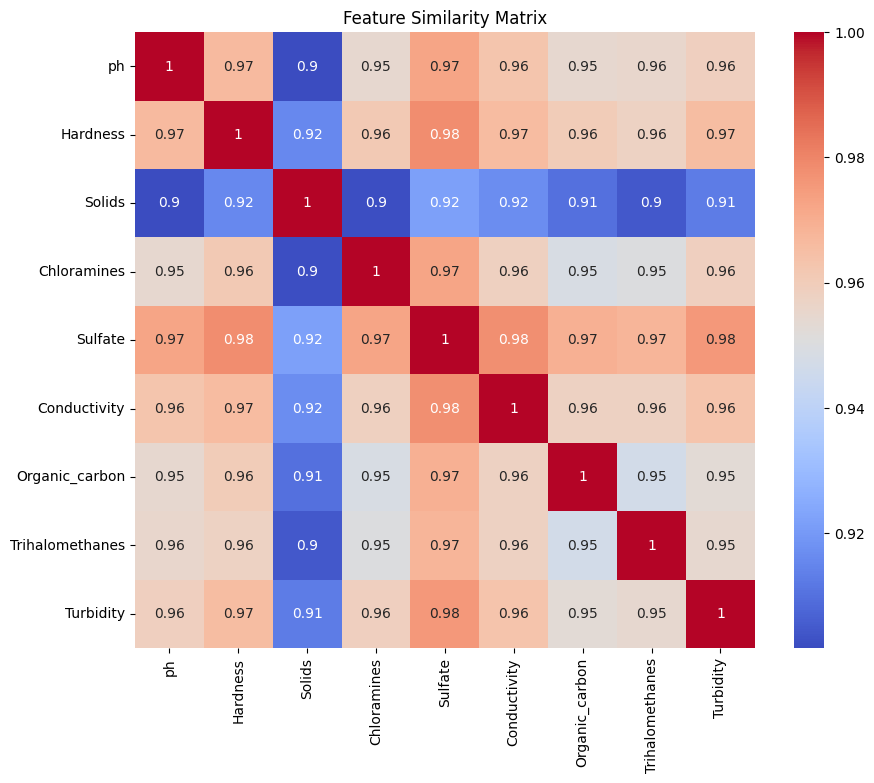

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np

# Fill missing values with column mean
X_test_filled = X_test.fillna(X_test.mean())

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(X_test_filled.T)
labels = X_test.columns

# Create a DataFrame for the similarity matrix
sim_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title('Feature Similarity Matrix')
plt.show()


In [ ]:
##Cross validation confuson matrix

In [ ]:
# Combine training and validation sets for cross-validation
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

In [ ]:
# # Cross-Validation Confusion Matrix
# from sklearn.model_selection import cross_val_predict
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# import numpy as np

# # Combine training and validation sets for cross-validation
# X_cv = pd.concat([X_train, X_valid])
# y_cv = pd.concat([y_train, y_valid])

# # Define the classifier without early stopping
# clf_cv = lgb.LGBMClassifier(**parameters)

# # Perform cross-validation and get predictions
# y_pred_cv = cross_val_predict(clf_cv, X_cv, y_cv, cv=5)

# # Compute the confusion matrix
# cm_cv = confusion_matrix(y_cv, y_pred_cv)

# # Plot the confusion matrix
# disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=np.unique(y_cv))
# disp_cv.plot(cmap=plt.cm.Blues)
# plt.title('Cross-Validation Confusion Matrix')
# plt.show()


In [ ]:
!pip install qiskit

ERROR: Could not find a version that satisfies the requirement qiskit (from versions: none)
ERROR: No matching distribution found for qiskit
